# Dataset Bespoke Subsampling Demo

This notebook demonstrates how to use the high-level analysis tooling from OG-MARL to inspect datasets.

In [15]:
from og_marl.vault_utils.download_vault import *
from og_marl.vault_utils.analyse_vault import analyse_vault
from flashbax.vault import Vault
import jax
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np
from og_marl.vault_utils.subsample_smaller import subsample_smaller_vault
from og_marl.vault_utils.subsample_similar import subsample_similar
from og_marl.vault_utils.combine_vaults import combine_vaults
from og_marl.vault_utils.analyse_vault import full_analysis
from og_marl.vault_utils.subsample_bespoke import bin_processed_data,episode_idxes_sampled_from_pdf
from og_marl.vault_utils.subsample_similar import sort_concat, stitch_vault_from_sampled_episodes_, get_episode_returns_and_term_idxes

See dataset_analysis_demo for more information on downloading and accessing OG-MARL vaults.

In [16]:
# download / make sure dataset exists
source = 'og_marl'
env = 'smac_v1'
task = '2s3z'

rel_vault_location = download_and_unzip_vault(source,env,task)
vault_uids = get_available_uids(rel_vault_location)

vault_rel_dir = f"vaults/{source}/{env}" # combine base vault directory with the dataset source and environment folders
vault_name = f"{task}.vlt" # a vault name contains only the file name which has the .vlt extension
vault_uid = vault_uids[0] # we select the first dataset in the vault

vlt = Vault(rel_dir=vault_rel_dir, vault_name=vault_name, vault_uid=vault_uid)

Vault './vaults/og_marl/smac_v1/2s3z' already exists.
Loading vault found at /home/louise/workspace/og-marl/examples/vaults/og_marl/smac_v1/2s3z.vlt/Poor


For further information about a Vault's api, please see the dataset api demo.

## Subsample a vault "by hand"

Given a histogram of episode returns, we allow subsampling a vault according to the histogram in a flexible way. That is, we allow individul specification of the size of each bucket.

### Dataset description to guide subsampling

In [17]:
# it can be useful to have experience handy at this level
all_data = vlt.read()
offline_data = all_data.experience
del all_data

In [18]:
returns, episode_end_idxes = get_episode_returns_and_term_idxes(offline_data)
sorted_return_start_end = sort_concat(returns,episode_end_idxes)
bar_labels, bar_heights, padded_heights, bin_edges, bin_numbers = bin_processed_data(sorted_return_start_end, n_bins=300)

9942
9942


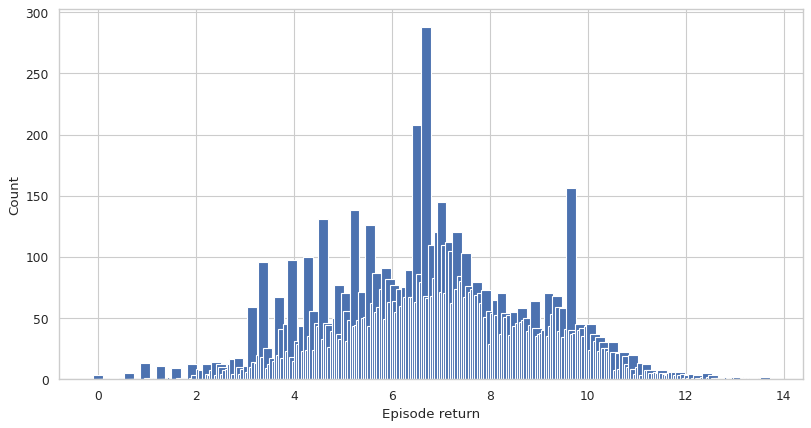

[  3   1   5  13   1   1  11   2   1   9   1   1  12   1   3   8   7  12
   4   3   7  14   3  12  10   4   7   8  12  16   4  17  10   4   8  11
   6  59  10  14  13  20  96  18  25   9  12  17  15  67  20  41  17  45
  23  97  18  15  31  29  43  23 100  24  35  56  24  46  43 131  33  46
  44  26  39  50  77  37  33  70  56  31  48 138  43  44  48  71  50  51
 126  43  62  87  55  59  74  91  49  82  63  77  64  55  74  60  75  67
  89  67  67 208  63  86  79 288  68  66 110  68  83 120 145  71 110  70
 112 105  62 120  74  84  80 103  67  76  71  74  79  69  70  62  73  51
  56  29  54  65  52  70  37  54  51  52  36  55  43  46  58  47  48  50
  39  44  64  42  35  37  38  40  70  35  43  53  68  59  39  58  34  41
 156  40  37  38  45  40  42  35  43  45  24  37  31  34  23  30  25  25
  23  30  22   7  21   8  22  19  12  10  20   8   4  10  13   3  12   7
   7   5   5   6   5   7   5   4   3   5   6   6   3   6   3   4   1   3
   1   4   1   3   1   2   5   2   3   1   1   1   

In [19]:
# print the histogram to show the distribution
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6), dpi=80)
plt.bar(bin_edges,padded_heights,width=0.2)
plt.ylabel("Count")
plt.xlabel("Episode return")
plt.show()

print(bar_heights)

### Plot a pdf under the distribution to specify how many episodes to sample

Although we allow manual specification of how many episodes to sample from each bucket, it can be easier to sample according to a distribution defined by a function. We use the Gaussian distribution as an example.

Important to note, we plot the distribution with bin numbers as the unit since it is dataset-agnostic.

In [20]:
def my_pdf(x_vals,x_shift,std_dev,volume):
    """
    x_vals: generally, the bin indices (excluding bins containing zero episodes)
    x_shift: defines the mean of the distribution
    std_dev: defines the slope of the pdf
    volume: volume*std_dev is the approximate number of sampled episodes
    """
    y_vals = norm.pdf((np.array((x_vals))-x_shift)/std_dev)*volume
    
    return y_vals

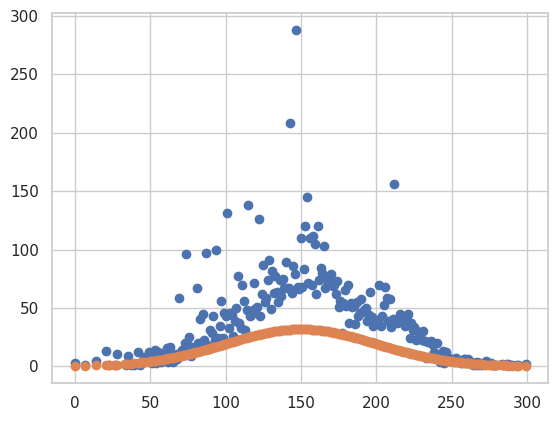

In [21]:
# visualise original distribution
plt.scatter(bar_labels,bar_heights)
norm_pdf_vals = my_pdf(bar_labels,150,50,80)
plt.scatter(bar_labels,norm_pdf_vals)
plt.show()

Generally, you want the sampling pdf to lie below the actual pdf. We allow for oversampling (then episodes are repeated), but it will in essence just impact the bias towards the resampled episodes.

In [22]:
# from each bin, select indexes to slice the return_start_end info block
target_sample_idxes = episode_idxes_sampled_from_pdf(norm_pdf_vals,bar_heights)

# do the selection according to the indices you just sampled
target_return_start_end = sorted_return_start_end[np.array(target_sample_idxes).astype(int),:]

[0 1 2]
[3]
[4 5 6 7 8]
[ 9 10 11 12 13 14 15 16 17 18 19 20 21]
[22]
[23]
[24 25 26 27 28 29 30 31 32 33 34]
[35 36]
[37]
[38 39 40 41 42 43 44 45 46]
[47]
[48]
[49 50 51 52 53 54 55 56 57 58 59 60]
[61]
[62 63 64]
[65 66 67 68 69 70 71 72]
[73 74 75 76 77 78 79]
[80 81 82 83 84 85 86 87 88 89 90 91]
[92 93 94 95]
[96 97 98]
[ 99 100 101 102 103 104 105]
[106 107 108 109 110 111 112 113 114 115 116 117 118 119]
[120 121 122]
[123 124 125 126 127 128 129 130 131 132 133 134]
[135 136 137 138 139 140 141 142 143 144]
[145 146 147 148]
[149 150 151 152 153 154 155]
[156 157 158 159 160 161 162 163]
[164 165 166 167 168 169 170 171 172 173 174 175]
[176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191]
[192 193 194 195]
[196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212]
[213 214 215 216 217 218 219 220 221 222]
[223 224 225 226]
[227 228 229 230 231 232 233 234]
[235 236 237 238 239 240 241 242 243 244 245]
[246 247 248 249 250 251]
[252 253 254 255 256 257 2

3941
3941


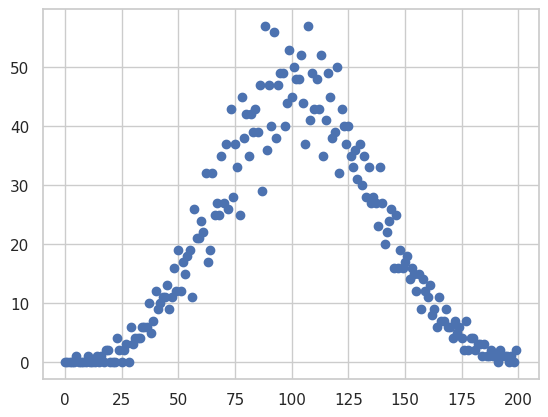

6.8533792
2.1648023


In [23]:
# visualise the subsampled distribution
bar_labels_t, bar_heights_t, padded_heights_t, bin_edges_t, bin_numbers_t = bin_processed_data(target_return_start_end, n_bins=200)
bins_t = range(len(padded_heights_t))
plt.scatter(bins_t,padded_heights_t)
plt.show()

# further print the mean and stddev of episode returns of the subsampled distribution
print(np.mean(target_return_start_end[:,0]))
print(np.std(target_return_start_end[:,0]))

## Now restitch the vault using the experience from before. 
A sanity check afterwards is recommended

In [25]:
dest_vault_name = 'temp_bespoke_subsampling'

stitch_vault_from_sampled_episodes_(offline_data,target_return_start_end,dest_vault_name,rel_dir=vault_rel_dir,vault_uid='test')

info = full_analysis(dest_vault_name,rel_dir=vault_rel_dir)

New vault created at /home/louise/workspace/og-marl/examples/vaults/og_marl/smac_v1/temp_bespoke_subsampling/test
Since the provided buffer state has a temporal dimension of 500000, you must write to the vault at least every 499999 timesteps to avoid data loss.
